<a href="https://colab.research.google.com/github/jnrkufuor/apollo/blob/Ernest/notebooks/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Load Packagaes

In [1]:
!pip install squarify

import pandas as pd
import numpy as np
import math
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
sns.set(rc={'figure.figsize':(20,15)})
import squarify
import statistics
#from google.colab import drive
#drive.mount('/content/drive')

tqdm.pandas()

  Using cached squarify-0.4.3-py3-none-any.whl (4.3 kB)


#2. Load data

##2.1 Load News Data

In [2]:
df_links = pd.read_csv('../data/df_links_2011_2015.csv')
print(len(df_links.index))

#hyperparamaters
weight_criteria = 6

1591


##2.2 Load Financial data

In [3]:
df_prices =  pd.read_csv('../data/price_corr.csv')
df_vol =  pd.read_csv('../data/volume_corr.csv')

df_finance_nds = pd.DataFrame(columns = ["from", "to", "weight"])

df_prices = df_prices.drop(df_prices.columns[0], axis=1)
df_prices.index = df_prices.columns

df_vol = df_vol.drop(df_vol.columns[0], axis=1)
df_vol.index = df_vol.columns

##2.3 Find Unique Pairs from Correlation Coefficient

In [4]:
# Get correlation pairs for Price and Volume
df_corr_price = df_prices[abs(df_prices) >= 0.0001].stack().reset_index()
df_corr_vol = df_vol[abs(df_vol) >= 0.0001].stack().reset_index()

#Take out lower triangle 
#for price
df_corr_price  = df_corr_price[df_corr_price['level_0'].astype(str)!=df_corr_price['level_1'].astype(str)]
df_corr_price['ordered-cols'] = df_corr_price.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#for volume
df_corr_vol  = df_corr_vol[df_corr_vol['level_0'].astype(str)!=df_corr_vol['level_1'].astype(str)]
df_corr_vol['ordered-cols'] = df_corr_vol.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#Remove duplicates and exclude self-correlated values
#for price
df_corr_price = df_corr_price.drop_duplicates(['ordered-cols'])
df_corr_price.reset_index(drop=True, inplace=True)
df_corr_price.drop(['ordered-cols'], axis=1, inplace=True)

#for volume
df_corr_vol = df_corr_vol.drop_duplicates(['ordered-cols'])
df_corr_vol.reset_index(drop=True, inplace=True)
df_corr_vol.drop(['ordered-cols'], axis=1, inplace=True)

#rename columns
df_corr_price.columns = ["from","to","correlation"]
df_corr_vol.columns = ["from","to","correlation"]

#3. Subset data

In [5]:
#Subset mews data. Count all links and store under weight column
df_links = df_links.groupby(['from', 'to']).size().reset_index()
df_links.rename(columns={0: 'weight'}, inplace=True)
df_links.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Frequency heatmap for Comention Matrix')

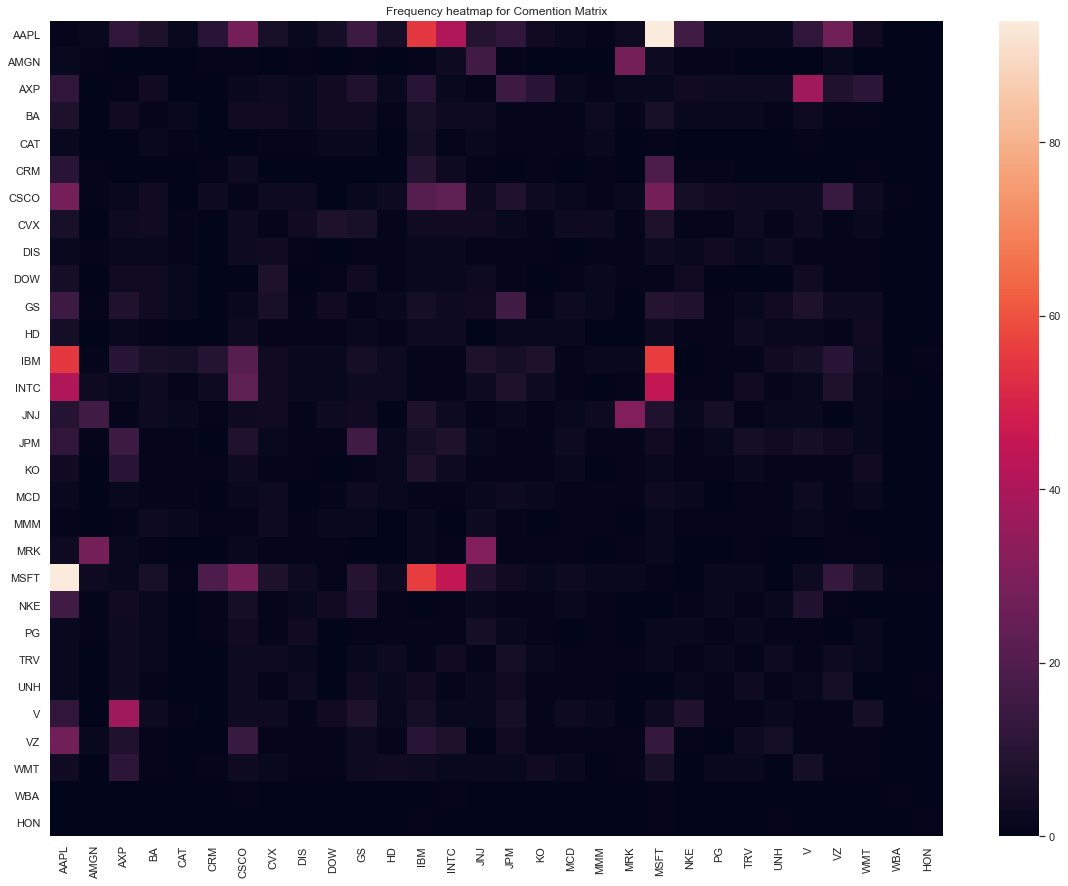

In [6]:
sns.set(rc={'figure.figsize':(20,15)})

#Build Co-mention Matrix
df_links[['from', 'to', 'weight']].sort_values('weight', ascending=False)
col=[]

#Extract Unique Columns
for row in df_links.iterrows():
    if row[1]['from'] not in col:
        col.append(row[1]['from'])
    if row[1]['to'] not in col:
        col.append(row[1]['to'])

df_matrix = pd.DataFrame(0,columns =col,index=col)

for row in df_links.iterrows():
    df_matrix[row[1]['from']][row[1]['to']] = row[1]['weight']
    df_matrix[row[1]['to']][row[1]['from']] = row[1]['weight']
    df_matrix[row[1]['from']][row[1]['from']] = 1
    df_matrix[row[1]['to']][row[1]['to']] = 1

#Construct Heatmap
sns.heatmap(df_matrix).set_title("Frequency heatmap for Comention Matrix")

In [7]:

#normalize values and create co-mention matrix - Use Z-score normmalization?
#df_links['weight'] =(df_links['weight']-df_links['weight'].min())/(df_links['weight'].max()-df_links['weight'].min())

#Use Hyper parameter for now
df_links = df_links[df_links['weight'] > weight_criteria]
df_links.head(10)

,from,to,weight
1,AAPL,AXP,8
2,AAPL,BA,7
4,AAPL,CRM,10
5,AAPL,CSCO,28
9,AAPL,GS,15
11,AAPL,IBM,55
12,AAPL,INTC,41
13,AAPL,JNJ,9
14,AAPL,JPM,12
19,AAPL,MSFT,94


##3.2 Subset Financial Nodes

In [8]:
#Subset financial Nodes using Stock Price and Volume Data
#If volume or price are above 0.8, add an edge between companies
#If volume and price are above 0.5 but less than 0.8, add an edge.
for i in range(1,len(df_corr_price)):
    if(abs(df_corr_price["correlation"][i]) > 0.8 or abs(df_corr_vol["correlation"][i]) > 0.8):
       df_finance_nds= df_finance_nds.append({"from" : df_corr_vol["from"][i], "to" : df_corr_vol["to"][i], "weight" : ((abs(df_corr_price["correlation"][i])+abs(df_corr_price["correlation"][i]))/2)},ignore_index=True)
    elif (abs(df_corr_price["correlation"][i]) < 0.8 and abs(df_corr_vol["correlation"][i]) < 0.8):
         if (abs(df_corr_price["correlation"][i]) >= 0.5 and abs(df_corr_vol["correlation"][i]) >= 0.5):
             df_finance_nds = df_finance_nds.append({"from" : df_corr_vol["from"][i], "to" : df_corr_vol["to"][i], "weight" : ((abs(df_corr_price["correlation"][i])+abs(df_corr_price["correlation"][i]))/2)},ignore_index=True)
df_finance_nds.head(10)


,from,to,weight
0,AXP,CAT,0.548812
1,AXP,CVX,0.510701
2,AXP,GS,0.653400
3,AXP,HD,0.519912
4,AXP,JPM,0.710496
5,AXP,TRV,0.559720
6,CAT,JPM,0.528654
7,CSCO,MSFT,0.567961
8,GS,JPM,0.721061
9,GS,TRV,0.506627


#4. Plot Edges

In [10]:
#create plot variables

#for news
df_plot_news = df_links
df_plot_news.reset_index(inplace=True, drop=True)

#for finance
df_plot_fin = df_finance_nds
df_plot_fin.reset_index(inplace=True, drop=True)
df_plots =[df_plot_news,df_plot_fin]

#Build Graph Variables
gr_news = nx.Graph() #news graph
gr_price = nx.Graph() #finacial graph
graph = [gr_news,gr_price]

#get a list of common nodes
joint_nodes = set(list(df_plots[0]['from'])).union(set(list(df_plots[0]['to']))) & set(list(df_plots[1]['from'])).union(set(list(df_plots[1]['to'])))

#add edges and nodes to graph

graph_num=0

for df_plot in df_plots:
    for link in tqdm(df_plot.index):
        graph[graph_num].add_edge(df_plot.iloc[link]['from'],
                  df_plot.iloc[link]['to'],
                  weight=df_plot.iloc[link]['weight'])
    graph_num+=1




100%|██████████| 14/14 [00:00<00:00, 1002.48it/s]


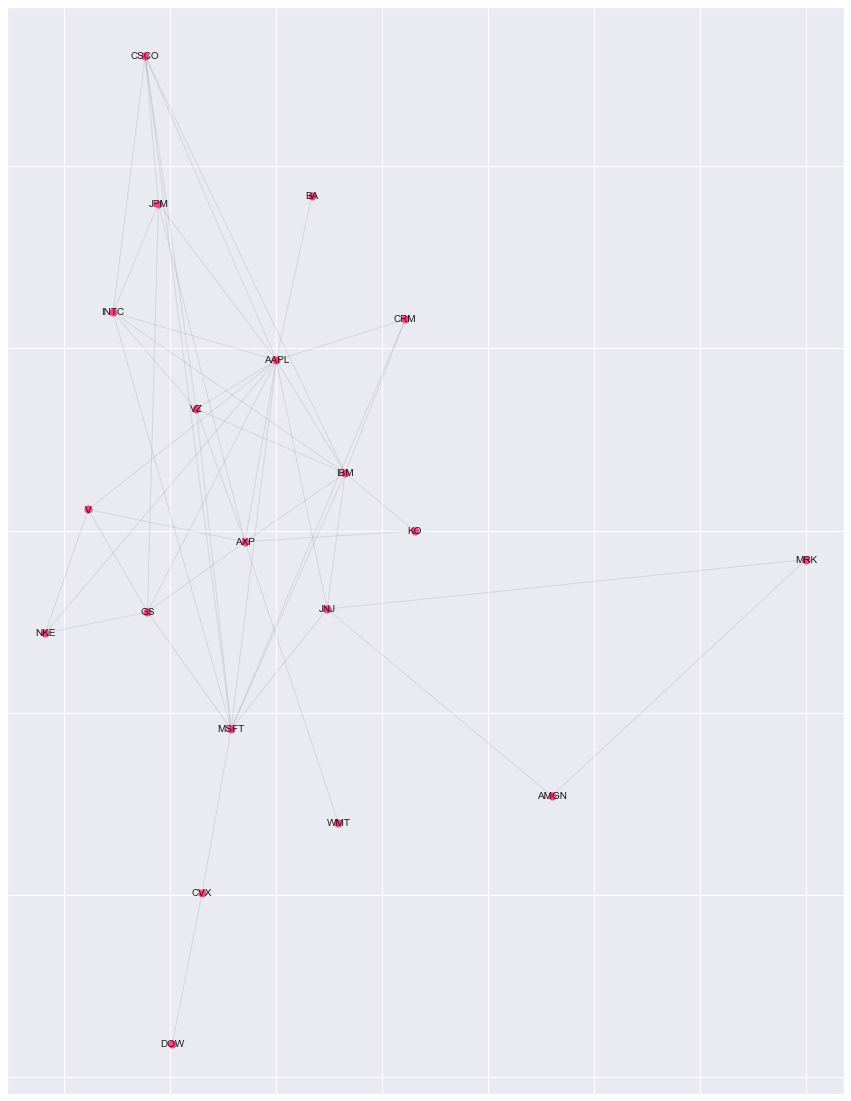

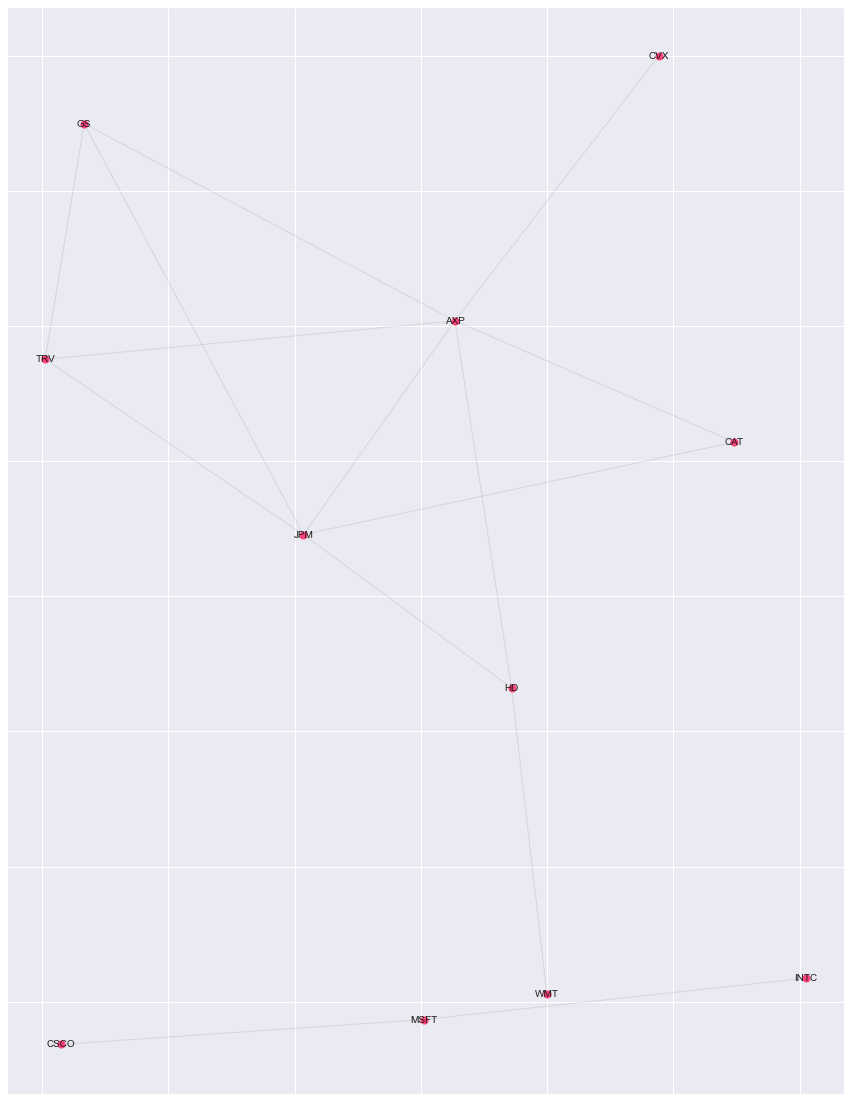

In [11]:
graph = [gr_news,gr_price]
node_labels = {} 
nodes_multi_layer={}
node_type=["t1","t2"]
type_count=0
for G in graph:
    pos = nx.kamada_kawai_layout(G)
    nodes = G.nodes()
    fig, axs = plt.subplots(1, 1, figsize=(15,20))

    el = nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axs)
    nl = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='#FF427b', 
                                node_size=50, ax=axs)
    ll = nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
   
    #createdictionary of nodes and labels
    node_count =0
    for node in G.nodes():
        #set the node name as the key and the label as its value 
        node_labels[node] = node

        #create nodes for multilayered graph
        nodes_multi_layer[node_count]={"node": node,"type":node_type[type_count]}

        #get like nodes
        

        node_count+=1
    type_count+=1
  

#5. Find Subgraphs

100%|██████████| 11/11 [00:00<00:00, 11029.73it/s]


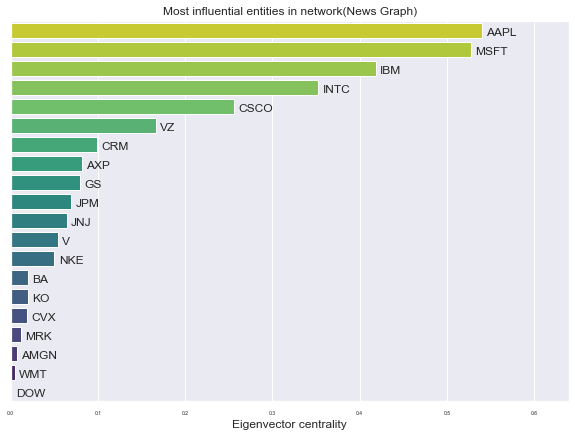

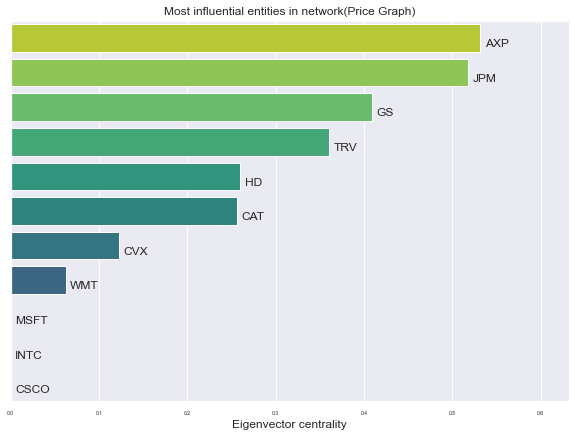

In [12]:
txt ="(News Graph)"
for G in graph:
    
    nodes = []
    eigenvector_cents = []
    ec_dict = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')
    for node in tqdm(G.nodes()):
      nodes.append(node)
      eigenvector_cents.append(ec_dict[node])

    df_centralities = pd.DataFrame(data={'entity': nodes,
                                        'eigenvector': eigenvector_cents})

    df_cent_top = df_centralities.sort_values('eigenvector', ascending=False).head(20)
    df_cent_top.reset_index(inplace=True, drop=True)
    fig, axs = plt.subplots(figsize=(10,7))
    g = sns.barplot(data=df_cent_top,
                x='eigenvector',
                y='entity',
                dodge=False,
                orient='h',
                hue='eigenvector',
                palette='viridis',)

    g.set_yticks([])
    g.set_title('Most influential entities in network'+txt)
    g.set_xlabel('Eigenvector centrality')
    g.set_ylabel('')
    g.set_xlim(0, max(df_cent_top['eigenvector'])+0.1)
    g.legend_.remove()
    g.tick_params(labelsize=5)

    for i in df_cent_top.index:
        g.text(df_cent_top.iloc[i]['eigenvector']+0.005, i+0.25, df_cent_top.iloc[i]['entity'])

    #sns.despine()
    g.get_figure().savefig('cent_plot.png', dpi=1000)
    txt ="(Price Graph)"
    nodes = []
    eigenvector_cents=[]


#6. Cliques

Finding the optimal number


In [13]:
from networkx.algorithms.community.kclique import k_clique_communities

100%|██████████| 28/28 [00:00<00:00, 4678.72it/s]


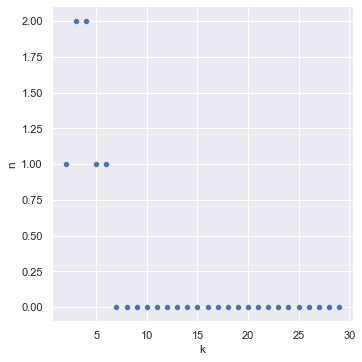

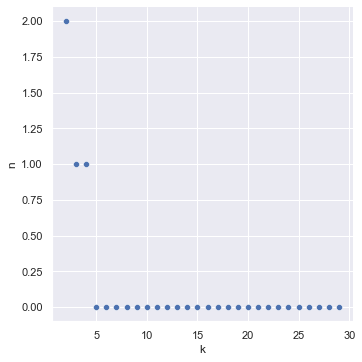

In [14]:
#Explore what the clique size per the nunmber of cliques for each graoh
clique_sizes = range(2, 30)
optimal_clique = [] #will hold the optimal clique size for each graph
for G in graph:
  n_cliques = []
  for k in tqdm(clique_sizes):
    n_cliques.append(len(list(k_clique_communities(G, k))))

  optimal_clique.append(2+(n_cliques.index(max(n_cliques)))) #clique sizes should be greater than one, hence least clique size is 2
 
  df_relplot = pd.DataFrame(data={'k': clique_sizes,
                                  'n': n_cliques})
  
  sns.relplot(data=df_relplot,
              x='k',
              y='n')

In [15]:
#General cliques using optimal minimum clique size array

cliques=[]
num=0
for G in graph:
    cliques.append(list(k_clique_communities(G, optimal_clique[num])))
    num+=1

Find centralities in cliques

In [16]:
#Find centralities within each clique
clx=[]
num = 0
for G in graph:
    eigenvector_cents = []
    entities = []
    clique_ids = []
    for id, clique in enumerate(cliques[num]):
      sg = G.subgraph(list(clique))

      nodes = sg.nodes()

      clique_ids.extend(np.repeat(id, len(nodes)))
      entities.extend(nodes)

      ec_dict = nx.eigenvector_centrality(sg, max_iter=1000, weight='weight')

      for entity in nodes:
        eigenvector_cents.append(ec_dict[entity])
    df_cliques = pd.DataFrame(data={
        'clique': clique_ids,
        'entity': entities,
        'centrality': eigenvector_cents
    })
    clx.append(df_cliques)
    num+=1
clx #index 0 = news graph, index 1 = price/vol graph

[    clique entity  centrality
 0        0   AAPL    0.539686
 1        0    AXP    0.081683
 2        0    CRM    0.098875
 3        0   CSCO    0.255944
 4        0     GS    0.079270
 5        0    IBM    0.418603
 6        0   INTC    0.352819
 7        0    JNJ    0.061870
 8        0    JPM    0.069478
 9        0   MSFT    0.527858
 10       0    NKE    0.049969
 11       0      V    0.053849
 12       0     VZ    0.166527
 13       0     KO    0.019303
 14       1   AMGN    0.530391
 15       1    JNJ    0.559135
 16       1    MRK    0.637223,
     clique entity  centrality
 0        0   MSFT    0.707107
 1        0   CSCO    0.484978
 2        0   INTC    0.514583
 3        1    AXP    0.531801
 4        1    CAT    0.255949
 5        1    CVX    0.122908
 6        1     GS    0.408848
 7        1     HD    0.259892
 8        1    JPM    0.517761
 9        1    TRV    0.360472
 10       1    WMT    0.062080]

In [17]:
#Color pallete for cliques
col_pal = {0: '#F1E8F3',
           1: '#A8DDFF',
           2: '#FF8A5B',
           3: '#74D3AE',
           4: '#93B7BE',
           5: '#D1B1CB',
           6: '#BAF2BB',
           7: '#FFA69E',
           8: '#97EAD2',
           9: '#34E4EA',
           10: '#B95F89',
           99:'#828A95'}

Plot Cliques

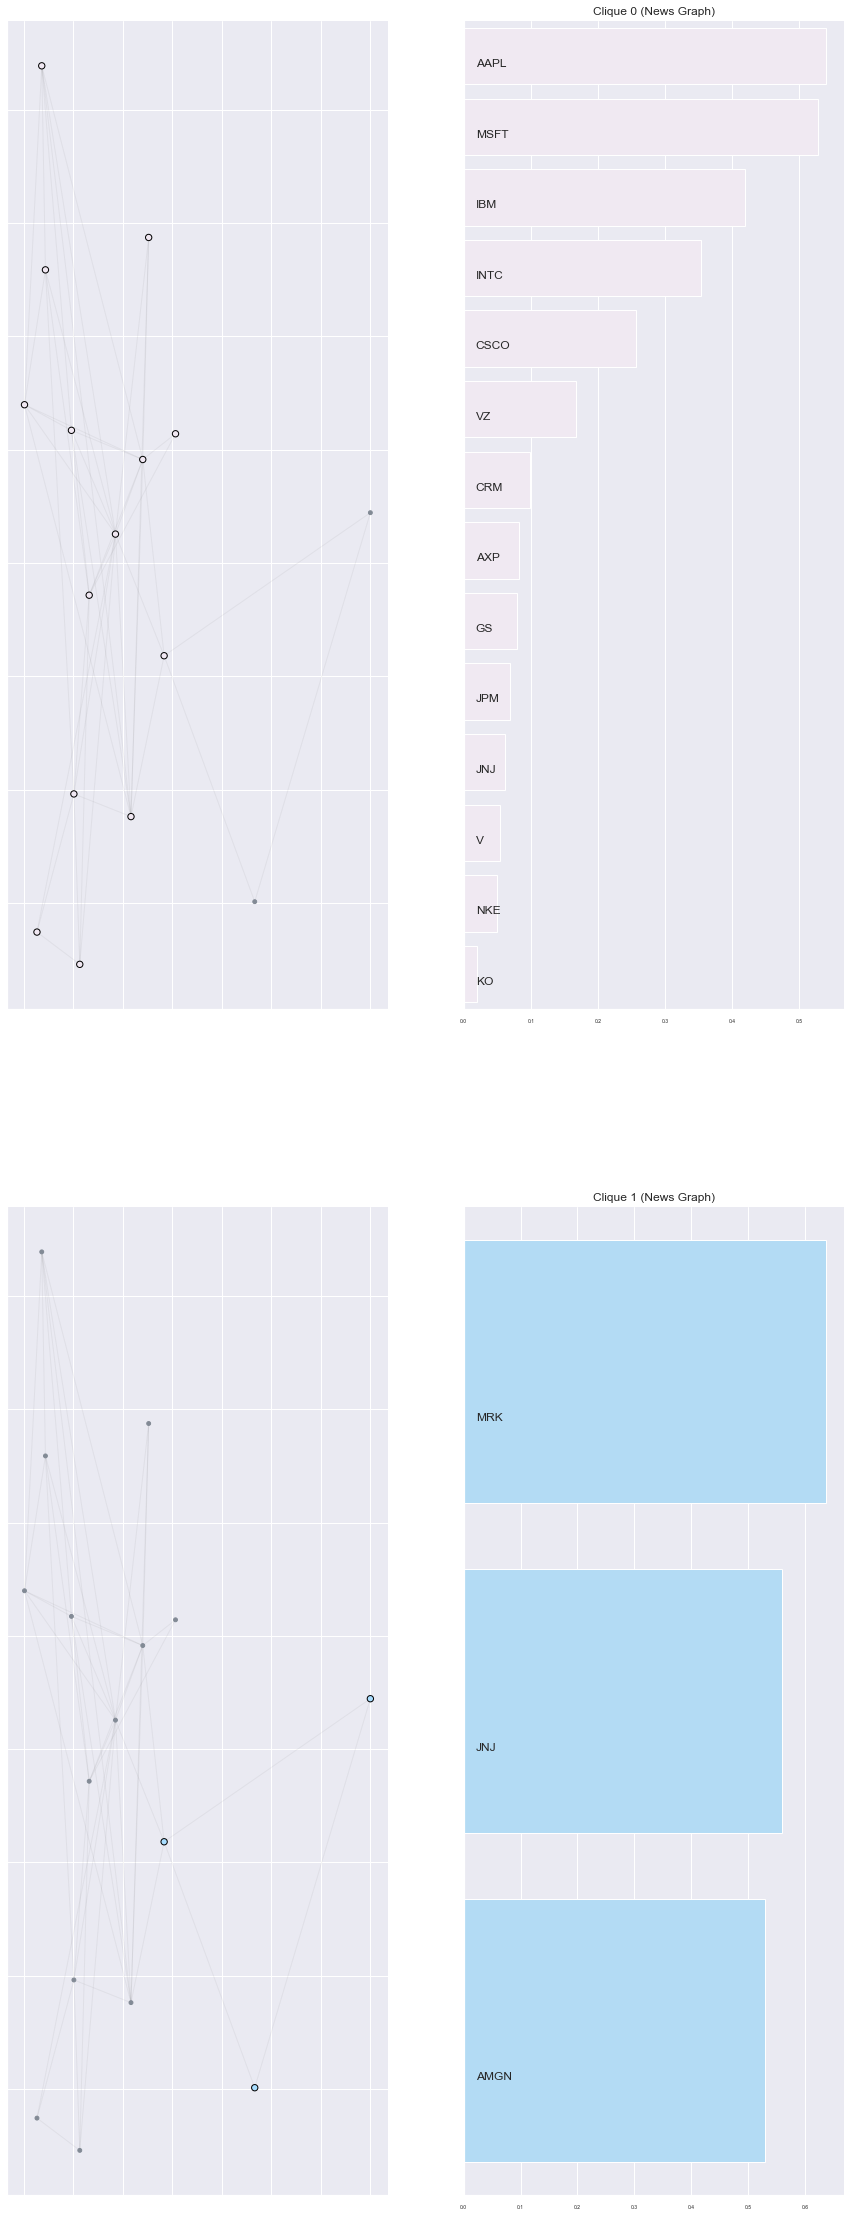

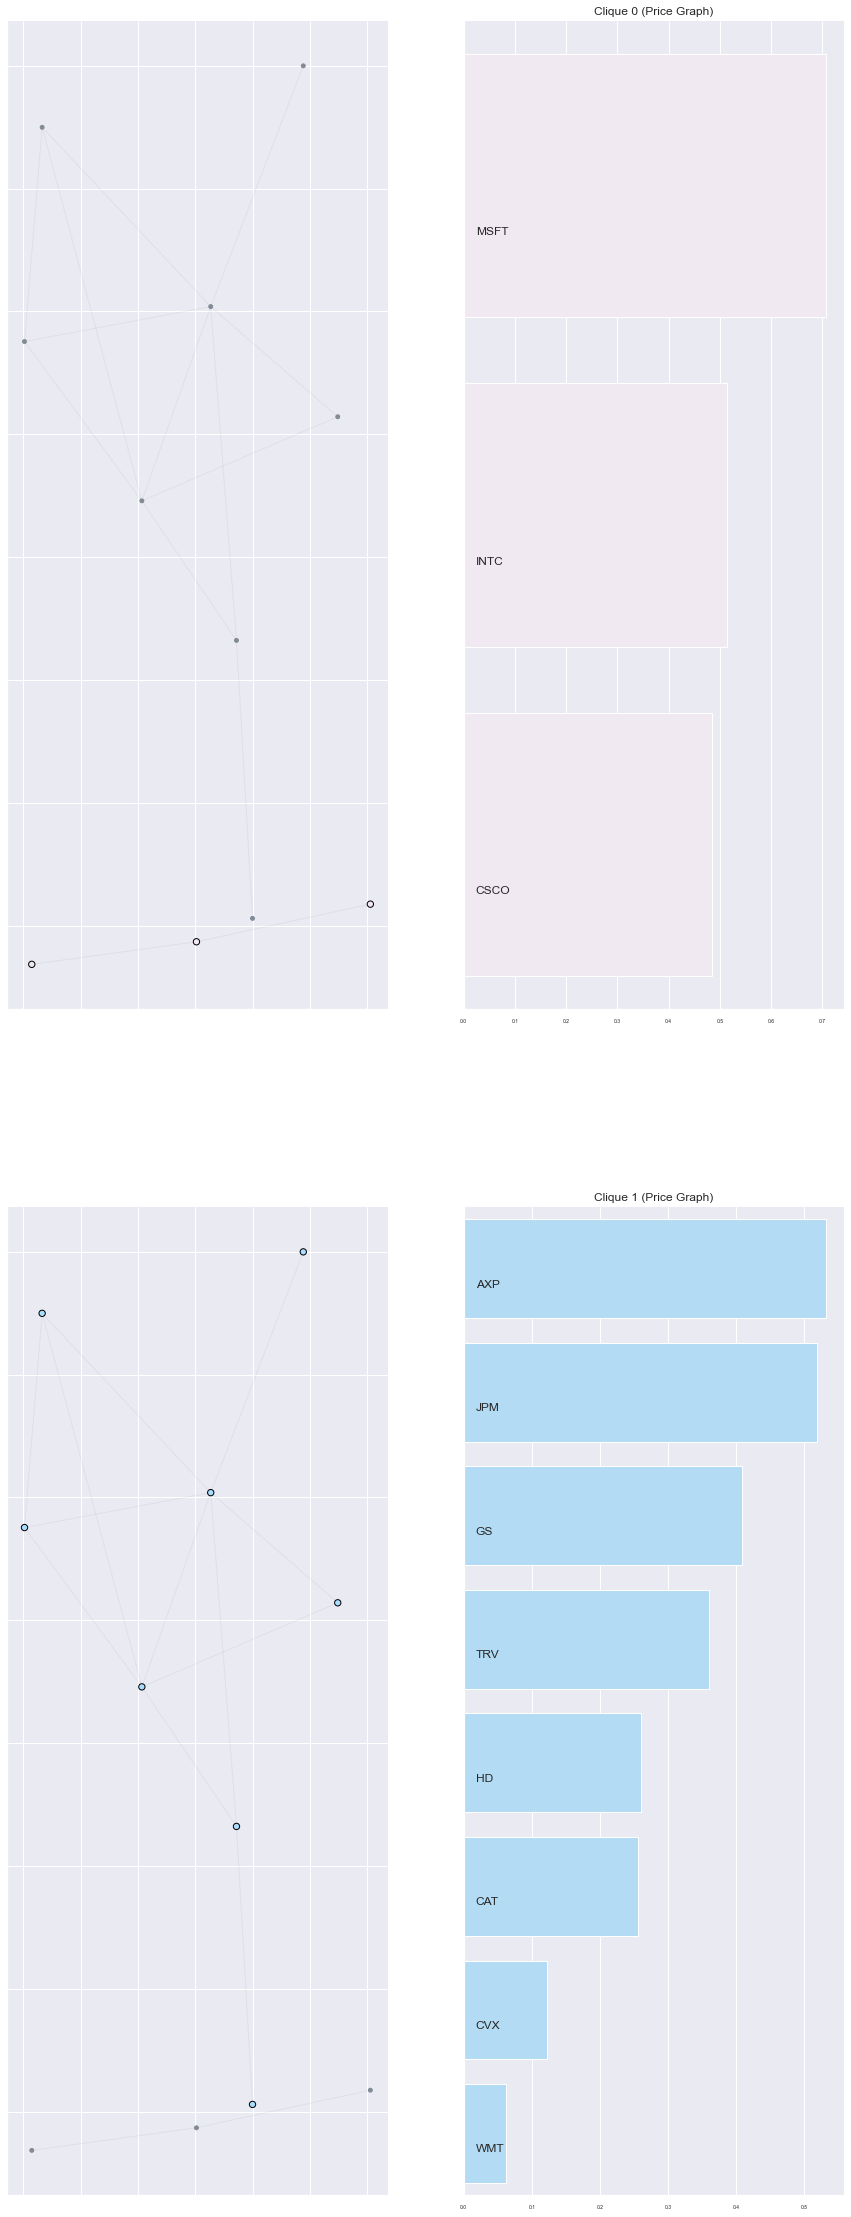

In [18]:
#Plot Cliques
clique_num=0
txt ="(News Graph)"
for G in graph:
   
    df_cliques = clx[clique_num]
    G_clique = G.subgraph(df_cliques['entity'].unique())
    pos = nx.kamada_kawai_layout(G_clique)
    nodes = G_clique.nodes()

    fig, axs = plt.subplots(max(df_cliques['clique'])+1, 2, figsize=(15,40))

    for clique in range(max(df_cliques['clique'])+1):
      node_colors = [col_pal[clique] if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]
      sizes = [40 if node in df_cliques[df_cliques['clique']==clique]['entity'].values else 15 for node in nodes]
      edge_colors = ['black' if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]

      ec = nx.draw_networkx_edges(G_clique, pos, alpha=0.05, ax=axs[clique, 0])
      nc = nx.draw_networkx_nodes(G_clique, pos, nodelist=nodes, node_color=node_colors, 
                                  node_size=sizes, ax=axs[clique, 0],
                                  edgecolors=edge_colors)
      
      df_clique_ind = df_cliques[df_cliques['clique']==clique]
      df_clique_ind = df_clique_ind.sort_values('centrality', ascending=False).head(15)
      df_clique_ind.reset_index(inplace=True, drop=True)

      g = sns.barplot(data=df_clique_ind,
                  x='centrality',
                  y='entity',
                  hue='clique',
                  palette=col_pal,
                  dodge=False,
                  orient='h',
                  ax=axs[clique, 1])
      
      g.set_yticks([])
      g.set_title(f'Clique {clique} {txt}')
      g.set_xlabel('')
      g.set_ylabel('')
      g.legend_.remove()
      g.tick_params(labelsize=5)
      

      for i in df_clique_ind.index:
        g.text(max(df_clique_ind['centrality'])/30, i+0.15, df_clique_ind.iloc[i]['entity'])

    txt ="(Price Graph)"  
    clique_num = clique_num+1
    sns.despine()


#4 Implement Multiplex Graph

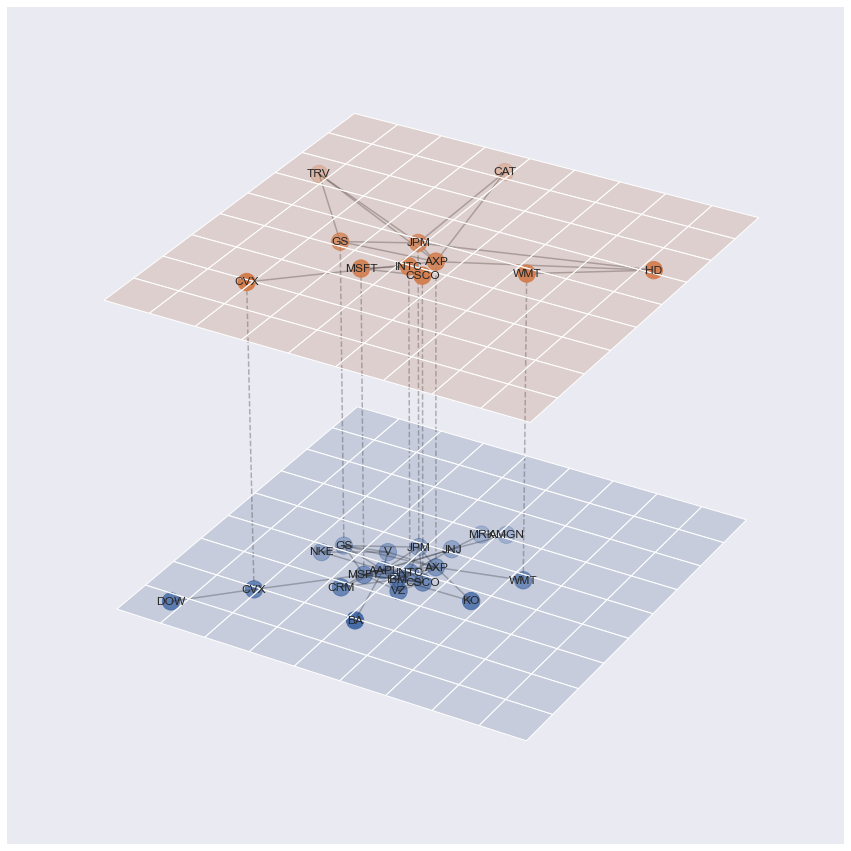

In [19]:
#install recommended packages
from LayeredNetworkGraph import LayeredNetworkGraph

# initialise figure and plot
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(111, projection='3d')
LayeredNetworkGraph([graph[0],graph[1]], node_labels=node_labels ,ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
plt.show()
fig.savefig('graph_images/multilayered.png', dpi=1000)
 

#Multiplex Graph using py3plex

In [49]:
!pip install py3plex
!pip install leidenalg
!pip install python-igraph
!pip install louvain
from py3plex.core import multinet
from py3plex.algorithms.community_detection import community_wrapper as cw
  ## get communities with multiplex louvain
import louvain
import igraph as ig
import leidenalg as la

ModuleNotFoundError: No module named 'leidenalg'

In [22]:
#for news
df_plot_news = df_links
df_plot_news.reset_index(inplace=True, drop=True)

#for finance
df_plot_fin = df_finance_nds
df_plot_fin.reset_index(inplace=True, drop=True)

df_plots =[df_plot_news,df_plot_fin]

#multiplex graph
A = multinet.multi_layer_network(network_type="multiplex")


#add nodes edges to graphs
type_num=0
edge_type=["co-mention","price/vol"]
layers=[0,1]

for df_plot in df_plots:
    for link in tqdm(df_plot.index):
        A.add_edges({"source":df_plot.iloc[link]['from'], "layer":layers[type_num], "target":df_plot.iloc[link]['to'],"type":edge_type[type_num],
                   "source_type":node_type[type_num], "weight":df_plot.iloc[link]['weight'],"target_type":node_type[type_num]})
    type_num+=1

#add edges between layers for common nodes in both layers
for n in joint_nodes:
    A.add_edges({"source":n,"source_type":"t1","target":n, "target_type":"t2"})




100%|██████████| 14/14 [00:00<00:00, 825.75it/s]


 12%|█▏        | 12/100 [00:00<00:00, 113.24it/s]-------------------- 
 Network splitting in progress 
 --------------------
100%|██████████| 100/100 [00:01<00:00, 75.18it/s]
BarnesHut Approximation  took  0.15  seconds
Repulsion forces  took  0.94  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds
Finished with layout..
Name: 
Type: MultiDiGraph
Number of nodes: 20
Number of edges: 50
Average in degree:   2.5000
Average out degree:   2.5000
100%|██████████| 1/1 [00:00<00:00, 17.17it/s]Name: 
Type: MultiDiGraph
Number of nodes: 11
Number of edges: 14
Average in degree:   1.2727
Average out degree:   1.2727



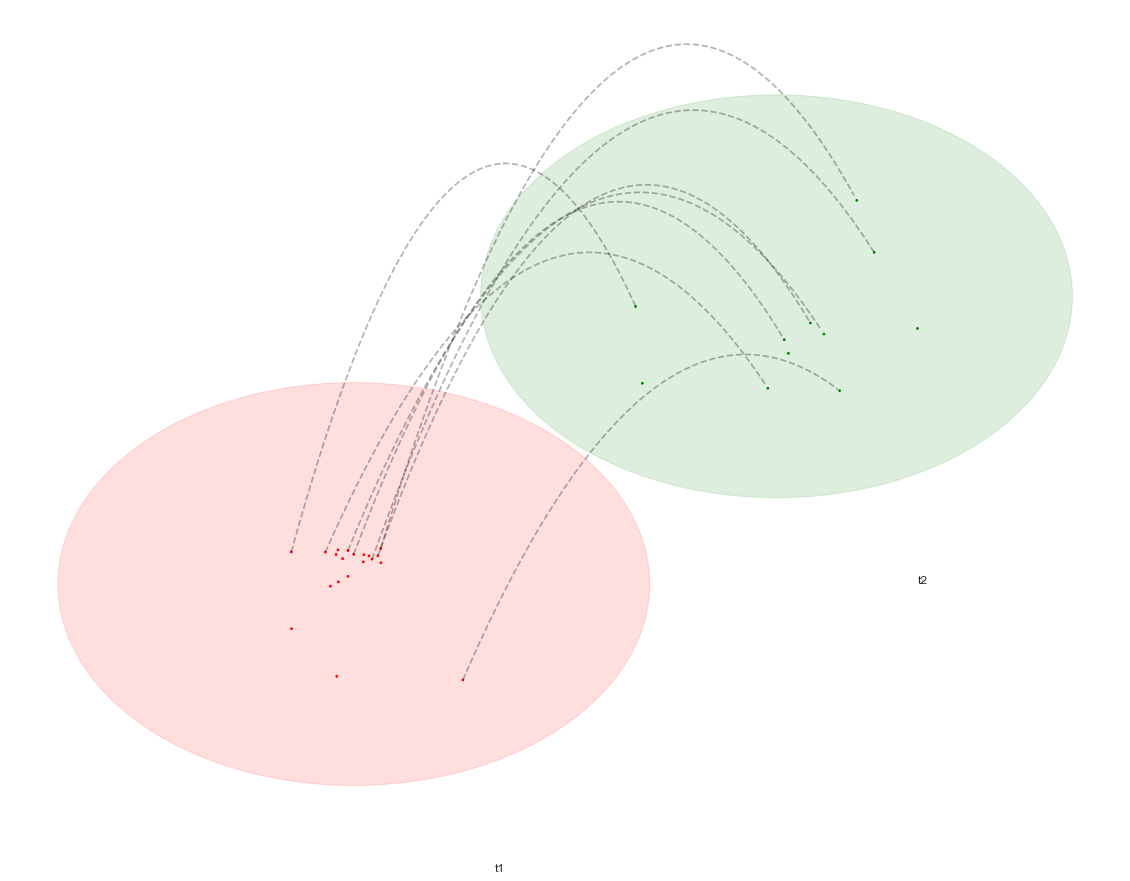

In [23]:
#A.basic_stats()
A.visualize_network(style="diagonal",show=True)


In [24]:
from collections import Counter

#Community Detection on Multiplex graph using the Louvain Method
partition = cw.louvain_communities(A)
dict(sorted(partition.items(), key=lambda item: item[1]))
partition


{('AAPL', 't1'): 0,
 ('AXP', 't1'): 1,
 ('BA', 't1'): 0,
 ('CRM', 't1'): 1,
 ('CSCO', 't1'): 1,
 ('GS', 't1'): 0,
 ('IBM', 't1'): 1,
 ('INTC', 't1'): 1,
 ('JNJ', 't1'): 2,
 ('JPM', 't1'): 1,
 ('MSFT', 't1'): 1,
 ('NKE', 't1'): 0,
 ('V', 't1'): 0,
 ('VZ', 't1'): 1,
 ('KO', 't1'): 1,
 ('WMT', 't1'): 3,
 ('AXP', 't2'): 3,
 ('CSCO', 't2'): 1,
 ('GS', 't2'): 3,
 ('INTC', 't2'): 1,
 ('MRK', 't1'): 2,
 ('JPM', 't2'): 3,
 ('MSFT', 't2'): 1,
 ('AMGN', 't1'): 2,
 ('WMT', 't2'): 3,
 ('CVX', 't1'): 4,
 ('DOW', 't1'): 4,
 ('CVX', 't2'): 4,
 ('CAT', 't2'): 3,
 ('HD', 't2'): 3,
 ('TRV', 't2'): 3}

  8%|▊         | 17/200 [00:00<00:01, 157.83it/s]
['red', 'green', 'red', 'green', 'green', 'red', 'green', 'green', 'navy', 'green', 'green', 'red', 'red', 'green', 'navy', 'navy', 'green', 'orange', 'red', 'red', 'orange', 'orange', 'red', 'orange', 'orange', 'orange', 'orange', 'green', 'green', 'orange', 'green']
Beginning parsing..
Using custom init positions!
100%|██████████| 200/200 [00:01<00:00, 138.29it/s]
BarnesHut Approximation  took  0.18  seconds
Repulsion forces  took  0.97  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


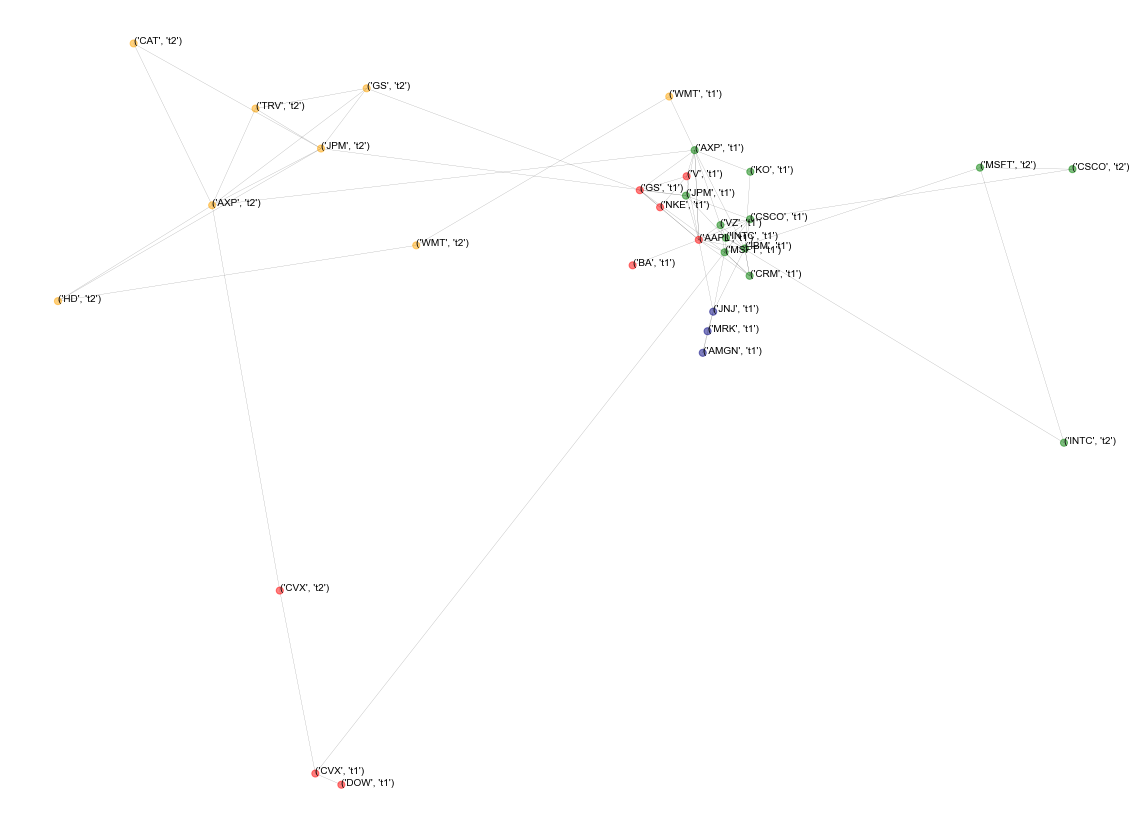

In [103]:
# select top n communities by size
from py3plex.visualization import colors
top_n = 10
partition_counts = dict(Counter(partition.values()))
top_n_communities = list(partition_counts.keys())[0:top_n]

color_mappings = dict(zip(top_n_communities,[x for x in colors.colors_default if x !="black"][0:top_n]))
network_colors = [color_mappings[partition[x]] if partition[x] in top_n_communities else "black" for x in A.get_nodes()]
nds =list(A.get_nodes())
#nds = [row[0] for row in nds]
#print(nds)
print(A.core_network)
print(network_colors)
#print(A.core_network)

# visualize the network's communities
visualize_partitions(A.core_network,
                    color_list=network_colors,
                    layout_parameters={"iterations": 200},
                    scale_by_size=True,
                    node_sizes= 50,
                    labels=nds,
                    edge_width=0.2,
                    label_font_size=10,
                    layout_algorithm="force",
                    legend=False)
plt.show()

In [97]:
def visualize_partitions(
        g,
        color_list=None,
        display=False,
        node_size=1,
        text_color="black",
        node_sizes=None,  # for custom sizes
        layout_parameters=None,
        legend=None,
        scale_by_size=True,
        layout_algorithm="force",
        edge_width=0.01,
        alpha_channel=0.5,
        labels=None,
        draw=True,
        label_font_size=2):

#    main_figure = plt.figure()
#    shape_subplot = main_figure.add_subplot(111)

    print("Beginning parsing..")
    nodes = g.nodes(data=True)
    potlabs = []
    #    fig, ax = plt.subplots()
    for node in nodes:
        try:
            potlabs.append(node[0][1])
        except:
            potlabs.append("unlabeled")

    if color_list is None:
        unique_colors = np.unique(potlabs)
        color_mapping = dict(zip(list(unique_colors), colors.colors_default))
        try:
            color_list = [color_mapping[n[1]['type']] for n in nodes]
        except:
            print("Assigning colors..")
            color_list = [1] * len(nodes)

    
    node_types = [x[1] for x in g.nodes()]
    assert len(node_types) == len(color_list)

    try:
        cols = color_list            
    except Exception as es:
        print("Using default palette")
        cols = colors.colors_default            
    id_col_map = {}
    for enx, j in enumerate(set(color_list)):
        id_col_map[j] = j
    id_type_map = dict(zip(color_list, node_types))
    final_color_mapping = [id_col_map[j] for j in color_list]
    color_to_type_map = {}
    for k, v in id_type_map.items():
        actual_color = id_col_map[k]
        color_to_type_map[actual_color] = id_type_map[k]

    degrees = dict(nx.degree(nx.Graph(g)))

    if scale_by_size:
        nsizes = [
            np.log(v) * node_size if v > 10 else v for v in degrees.values()
        ]
    else:
        nsizes = [node_size for x in g.nodes()]

    if not node_sizes is None:
        nsizes = node_sizes

    # standard force -- directed layout
    if layout_algorithm == "force":
        pos = multinet.compute_force_directed_layout(g, layout_parameters)

    # random layout -- used for initialization of more complex algorithms
    elif layout_algorithm == "random":
        pos = multinet.compute_random_layout(g)

    elif layout_algorithm == "custom_coordinates":
        pos = layout_parameters['pos']

    elif layout_algorithm == "custom_coordinates_initial_force":
        pos = multinet.compute_force_directed_layout(g, layout_parameters)
    else:
        raise ValueError('Uknown layout algorithm: ' + str(layout_algorithm))

    if draw:
        nx.draw_networkx_edges(g,
                               pos,
                               alpha=alpha_channel,
                               edge_color="black",
                               width=edge_width,
                               arrows=False)
        scatter = nx.draw_networkx_nodes(g,
                                         pos,
                                         nodelist=[n1[0] for n1 in nodes],
                                         node_color=final_color_mapping,
                                         node_size=nsizes,
                                         alpha=alpha_channel)
    if labels is not None:
        for el in labels:
            pos_el = pos[el]
            if draw:
                plt.text(pos_el[0],
                         pos_el[1],
                         el,
                         fontsize=label_font_size,
                         color=text_color)


#        nx.draw_networkx_labels(g, pos, font_size=label_font_size)

    plt.axis('off')

    #  add legend {"color":"string"}
    if legend is not None and legend:
        legend_colors = set(id_col_map.values())
        if len(legend_colors) > 6:
            fs = "small"
        else:
            fs = "medium"
        markers = [
            plt.Line2D([0, 0], [0, 0], color=key, marker='o', linestyle='')
            for key in legend_colors
        ]
        if draw:
            plt.legend(markers,
                       [color_to_type_map[color] for color in legend_colors],
                       numpoints=1,
                       fontsize=fs)

    if display:
        plt.show()

    if not draw:
        return g, nsizes, final_color_mapping, pos

In [ ]:
#community detection alternative


     #optimiser = louvain.Optimiser()
#print(A.separate_layers)
#A.split_to_layers(style = "none")
network_list = []

     ## cast this to igraph
unique_node_id_counter = 0
node_hash = {}
for layer in A.separate_layers:
    g = ig.Graph()
    edges_all = []
    for edge in layer.edges():
        first_node = edge[0][0]
        second_node = edge[1][0]
        g.add_vertex(first_node)
        g.add_vertex(second_node)
        edges_all.append((first_node,second_node))
        #print(edges_all)
        g.add_edges(edges_all)
        network_list.append(g)

#membership, improv = la.find_partition_multiplex(
                       #network_list,la.ModularityVertexPartition);

membership, improv = louvain.find_partition_multiplex(
                       network_list,la.ModularityVertexPartition);

     ## for each node we get community assignment.
A.monitor(membership)
A.monitor(improv)